In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, roc_curve, auc
)
import mlflow

In [29]:
# Load dataset
df = pd.read_csv("ecommerce_customer_data_custom_ratios.csv")


In [30]:
# Data preprocessing
df.drop('Age', axis=1, inplace=True)  # Drop unnecessary columns
df['Returns'].fillna(df['Returns'].mean(), inplace=True)  # Handle missing data

C:\Users\acer\AppData\Local\Temp\ipykernel_32104\2299851225.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Returns'].fillna(df['Returns'].mean(), inplace=True)  # Handle missing data


In [31]:
# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Gender', 'Payment Method', 'Product Category'], drop_first=True)

In [32]:
# Define feature matrix (X) and target vector (y)
X = df[['Product Price', 'Quantity', 'Total Purchase Amount', 'Customer Age', 
        'Returns', 'Gender_Male', 
        'Payment Method_Credit Card', 'Payment Method_Crypto',
        'Payment Method_PayPal', 
        'Product Category_Clothing', 'Product Category_Electronics',
        'Product Category_Home']]
y = df["Churn"]

In [33]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=101)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=101)

In [35]:
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=2000, solver='lbfgs')
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

c:\Users\acer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
# Confusion matrix and classification report
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("Confusion Matrix - Logistic Regression:")
print(cm_log_reg)
print(classification_report(y_test, y_pred_log_reg))

Confusion Matrix - Logistic Regression:
[[41581 18434]
 [17512 42549]]
              precision    recall  f1-score   support

           0       0.70      0.69      0.70     60015
           1       0.70      0.71      0.70     60061

    accuracy                           0.70    120076
   macro avg       0.70      0.70      0.70    120076
weighted avg       0.70      0.70      0.70    120076



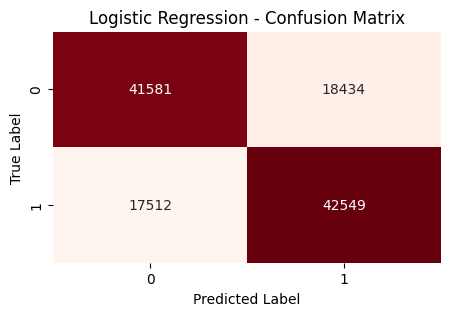

In [48]:
# Plot Confusion Matrix for Logistic Regression
plt.figure(figsize=(5, 3))
sns.heatmap(cm_log_reg, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

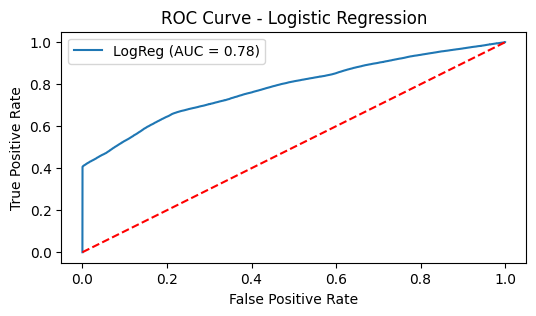

In [38]:
# ROC Curve for Logistic Regression
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob_log_reg)
roc_auc_log_reg = auc(fpr, tpr)

plt.figure(figsize=(6, 3))
plt.plot(fpr, tpr, label=f'LogReg (AUC = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [39]:
# Track Train vs Test Accuracy for Logistic Regression
C_values = np.logspace(-4, 4, 10)  # Regularization parameter values
train_accuracies_log = []
test_accuracies_log = []

for C in C_values:
    log_reg_iter = LogisticRegression(C=C, max_iter=2000, solver='lbfgs', random_state=101)
    log_reg_iter.fit(X_train, y_train)
    train_accuracies_log.append(accuracy_score(y_train, log_reg_iter.predict(X_train)))
    test_accuracies_log.append(accuracy_score(y_test, log_reg_iter.predict(X_test)))


c:\Users\acer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\acer\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

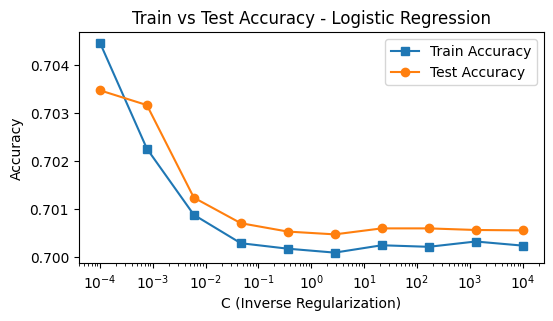

In [46]:
# Plot Train vs Test Accuracies for Logistic Regression
plt.figure(figsize=(6, 3))
plt.plot(C_values, train_accuracies_log, label='Train Accuracy', marker='s')
plt.plot(C_values, test_accuracies_log, label='Test Accuracy', marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy - Logistic Regression')
plt.legend()
plt.show()

In [49]:
# Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'class_weight': ['balanced', None]
}

rf = RandomForestClassifier(random_state=101)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best estimator from grid search
best_rf = grid_search.best_estimator_

# Evaluate the modelA
y_pred_rf = best_rf.predict(X_test)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


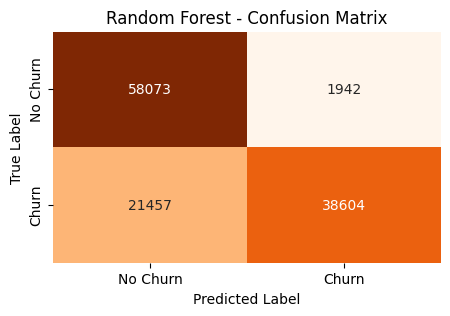

In [52]:

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(5, 3))
sns.heatmap(cm_rf, annot=True, cmap='Oranges', fmt='d', cbar=False, 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


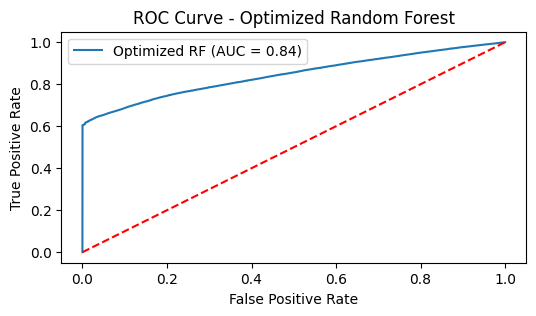

In [53]:

# ROC Curve for Random Forest
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(6, 3))
plt.plot(fpr_rf, tpr_rf, label=f'Optimized RF (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimized Random Forest')
plt.legend()
plt.show()


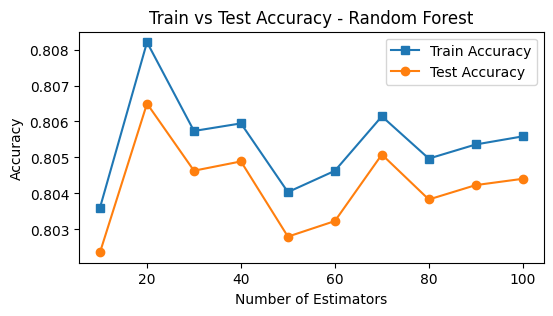

In [54]:
# Track Model Performance across Iterations for Random Forest
train_accuracies = []
test_accuracies = []

for n in range(10, 101, 10):
    rf_iter = RandomForestClassifier(n_estimators=n, max_depth=10, 
                                     min_samples_split=5, min_samples_leaf=2,
                                     random_state=101)
    rf_iter.fit(X_train, y_train)
    train_accuracies.append(accuracy_score(y_train, rf_iter.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, rf_iter.predict(X_test)))

# Plot Train vs Test Accuracies
plt.figure(figsize=(6, 3))
plt.plot(range(10, 101, 10), train_accuracies, label='Train Accuracy', marker='s')
plt.plot(range(10, 101, 10), test_accuracies, label='Test Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy - Random Forest')
plt.legend()
plt.show()

In [58]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

mlflow.set_experiment("Logistic Regression")

# Start an MLflow run
with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("solver", "lbfgs")
    mlflow.log_param("max_iter", 2000)

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_test, y_pred_log_reg),
        'recall_class_0': cm_log_reg[0, 0] / sum(cm_log_reg[0]),
        'recall_class_1': cm_log_reg[1, 1] / sum(cm_log_reg[1]),
        'roc_auc': roc_auc_log_reg
    })

    # Log the trained model
    mlflow.sklearn.log_model(log_reg, "logistic_regression_model")

2024/10/16 21:24:35 INFO mlflow.tracking.fluent: Experiment with name 'Logistic Regression' does not exist. Creating a new experiment.
2024/10/16 21:24:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/16 21:24:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run vaunted-boar-952 at: http://127.0.0.1:5000/#/experiments/7/runs/bb5cda251d0144ed82c58b81bb21886d.
2024/10/16 21:24:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/7.


Logistic Regression model logged successfully in MLflow.


In [59]:
mlflow.set_experiment("Random Forest")

# Start a new MLflow run
with mlflow.start_run():
    # Log hyperparameters of the best model
    mlflow.log_param("n_estimators", grid_search.best_params_['n_estimators'])
    mlflow.log_param("max_depth", grid_search.best_params_['max_depth'])
    mlflow.log_param("min_samples_split", grid_search.best_params_['min_samples_split'])
    mlflow.log_param("min_samples_leaf", grid_search.best_params_['min_samples_leaf'])

    # Log metrics
    mlflow.log_metrics({
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'recall_class_0': cm_rf[0, 0] / sum(cm_rf[0]),  # Recall for class 0 (no churn)
        'recall_class_1': cm_rf[1, 1] / sum(cm_rf[1]),  # Recall for class 1 (churn)
        'roc_auc': roc_auc_rf
    })

    # Log the best Random Forest model
    mlflow.sklearn.log_model(best_rf, "random_forest_model")

2024/10/16 21:24:57 INFO mlflow.tracking.fluent: Experiment with name 'Random Forest' does not exist. Creating a new experiment.
2024/10/16 21:25:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/16 21:25:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run loud-chimp-218 at: http://127.0.0.1:5000/#/experiments/8/runs/09d464cabf0047d5ab532ae3fe22bf78.
2024/10/16 21:25:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/8.


In [60]:
# Register Models in MLflow
log_reg_uri = "runs:/bb5cda251d0144ed82c58b81bb21886d/logistic_regression_model"
rf_uri = "runs:/09d464cabf0047d5ab532ae3fe22bf78/random_forest_model"
mlflow.register_model(model_uri=log_reg_uri, name="LogisticRegressionModel")
mlflow.register_model(model_uri=rf_uri, name="RandomForestModel")

Registered model 'LogisticRegressionModel' already exists. Creating a new version of this model...
2024/10/16 21:25:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LogisticRegressionModel, version 4
Created version '4' of model 'LogisticRegressionModel'.
Registered model 'RandomForestModel' already exists. Creating a new version of this model...
2024/10/16 21:25:20 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: RandomForestModel, version 4
Created version '4' of model 'RandomForestModel'.


<ModelVersion: aliases=[], creation_timestamp=1729103120181, current_stage='None', description='', last_updated_timestamp=1729103120181, name='RandomForestModel', run_id='09d464cabf0047d5ab532ae3fe22bf78', run_link='', source='file:///C:/Users/acer/artifacts/8/09d464cabf0047d5ab532ae3fe22bf78/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='', version='4'>